Libraries

In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except Exception:
    print("TPU not found")

In [4]:
IMG_SIZE = (150, 150)
IMG_PATH = "/content/face_images"
BATCH_SIZE = 32

Reading Dataset

In [5]:
def read_image(file_path: str):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=IMG_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    return img

def read_dataset():
    images, labels = [], []
    for file_path in tqdm(glob(IMG_PATH + "/*/*.jpg")):
        images.append(read_image(file_path))
        if "female" in file_path:
            labels.append(0)
        else:
            labels.append(1)

    return np.array(images), np.array(labels)

In [6]:
# Reading dataset and splitting into train set and validation set
images, labels = read_dataset()

trainImages, validImages, trainLabels, validLabels = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=21)

train_ds = (trainImages, trainLabels)
valid_ds = (validImages, validLabels)

print("Train Size: ", len(train_ds[0]))
print("Valid Size: ", len(valid_ds[0]))

del trainImages, validImages, trainLabels, validLabels

100%|██████████| 22801/22801 [00:50<00:00, 454.38it/s]


Train Size:  18240
Valid Size:  4561


In [7]:
classes = ['female', 'male']
print(classes)

['female', 'male']


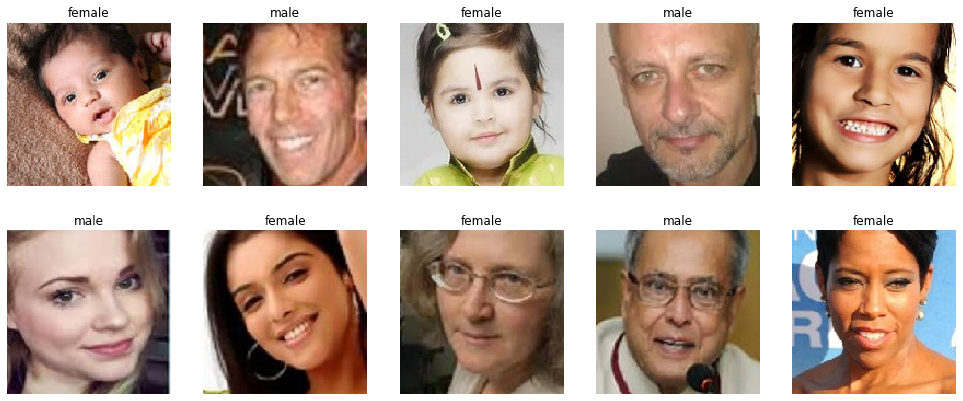

In [8]:
# Display some images
plt.figure(figsize=(17, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_ds[0][i], interpolation="nearest")
    plt.title(classes[train_ds[1][i]])
    plt.axis("off")

ANN

In [10]:
def get_classifier():
    input_layer = layers.Input(shape=(*IMG_SIZE, 3))
    layer = layers.experimental.preprocessing.Rescaling(1. / 255)(input_layer)
    
    # VGG Model
    vgg_model = VGG16(input_tensor=layer, include_top=False, weights="imagenet")
        
    layer = layers.Flatten()(vgg_model.output)
    layer = layers.Dense(512, activation="relu")(layer)
    layer = layers.Dense(128, activation="linear")(layer)
    layer = layers.Dense(32, activation="relu")(layer)
    layer = layers.Dense(1, activation="sigmoid")(layer)
    
    classifier = tf.keras.models.Model(inputs=input_layer, outputs=layer)
    
    classifier.compile(
        optimizer=tf.optimizers.Adam(learning_rate=1e-4),
        loss=tf.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )
    
    return classifier

with tpu_strategy.scope():
    classifier = get_classifier()

Training

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    mode="min", 
    monitor="val_loss", 
    patience=2,
    restore_best_weights=True
)

classifier_history = classifier.fit(
    train_ds[0],
    train_ds[1],
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    callbacks=early_stopping
)

Epoch 1/50
570/570 [==============================] - 49s 51ms/step - loss: 0.3418 - accuracy: 0.8473 - val_loss: 0.2651 - val_accuracy: 0.8921
Epoch 2/50
570/570 [==============================] - 18s 32ms/step - loss: 0.2130 - accuracy: 0.9163 - val_loss: 0.2284 - val_accuracy: 0.9105
Epoch 3/50
570/570 [==============================] - 18s 32ms/step - loss: 0.1749 - accuracy: 0.9321 - val_loss: 0.2674 - val_accuracy: 0.8954
Epoch 4/50
570/570 [==============================] - 18s 32ms/step - loss: 0.1471 - accuracy: 0.9474 - val_loss: 0.2196 - val_accuracy: 0.9134
Epoch 5/50
570/570 [==============================] - 18s 32ms/step - loss: 0.1202 - accuracy: 0.9582 - val_loss: 0.2061 - val_accuracy: 0.9202
Epoch 6/50
570/570 [==============================] - 18s 32ms/step - loss: 0.1044 - accuracy: 0.9651 - val_loss: 0.2385 - val_accuracy: 0.9116
Epoch 7/50
570/570 [==============================] - 18s 32ms/step - loss: 0.0845 - accuracy: 0.9734 - val_loss: 0.2491 - val_accuracy:

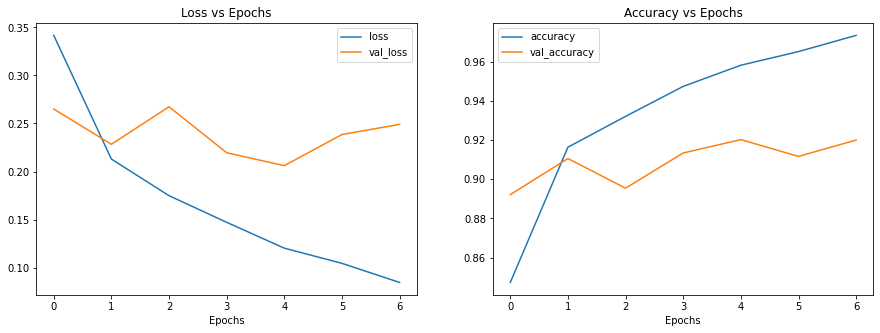

In [12]:
plt.figure(figsize=(15, 5))

# Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(classifier_history.history.get("loss"))
plt.plot(classifier_history.history.get("val_loss"))
plt.xticks(range(len(classifier_history.history.get("loss"))))
plt.legend(["loss", "val_loss"])
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")

# Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(classifier_history.history.get("accuracy"))
plt.plot(classifier_history.history.get("val_accuracy"))
plt.xticks(range(len(classifier_history.history.get("accuracy"))))
plt.legend(["accuracy", "val_accuracy"])
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")

plt.show()

Evaluation

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

y_true = valid_ds[1]
y_pred = classifier.predict(valid_ds[0]).ravel()

accuracy_list = []

# Thresholds
tpr, fpr, threshold = roc_curve(y_true, y_pred)

# Accuracy score based on different threshold
for thresh in threshold:
    thresh_y_pred = np.where(y_pred > thresh, 1, 0)
    accuracy_list.append((thresh, accuracy_score(y_true, thresh_y_pred)))
    
accuracy_list = pd.DataFrame(accuracy_list, columns=["threshold", "accuracy"], index=None)
accuracy_list.sort_values(by="accuracy", ascending=False, inplace=True)

# Thresholds with highest accuracy
best_threshold = accuracy_list.threshold.iloc[0]
accuracy_list.head()

,threshold,accuracy
312,0.362839,0.923920
303,0.385496,0.923920
302,0.391764,0.923701
313,0.361456,0.923701
311,0.363369,0.923701


In [14]:
print("Accuracy Score: 0.5 threshold")
print(accuracy_score(y_true, np.where(y_pred > 0.5, 1, 0)))

print(f"\nAccuracy Score: {best_threshold} threshold")
print(accuracy_score(y_true, np.where(y_pred > best_threshold, 1, 0)))

Accuracy Score: 0.5 threshold
0.9201929401447051

Accuracy Score: 0.3628387153148651 threshold
0.9239201929401447


Predicting

In [15]:
import dlib
import requests

face_detecter = dlib.get_frontal_face_detector()
def detect_face(image: np.ndarray):
    expand = 30
    rects = face_detecter(image, 1)
    for i, rect in enumerate(rects[:1]):
        face_image = image[rect.top() - expand : rect.bottom() + expand, rect.left() - expand : rect.right() + expand]
        face_image = cv2.resize(face_image, (IMG_SIZE))
        return face_image
    return None

def get_random_google_images():
    # Unsplash urls
    urls = [
        "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1494790108377-be9c29b29330?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1557296387-5358ad7997bb?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=788&q=80",
        "https://images.unsplash.com/photo-1493106819501-66d381c466f1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1577975819014-2d6f1e721e77?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1100&q=80",
        "https://images.unsplash.com/photo-1603775020644-eb8decd79994?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1509868918748-a554ad25f858?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1618716060974-98b20e2395cd?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=800&q=80",
        "https://images.unsplash.com/photo-1521227889351-bf6f5b2e4e37?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1250&q=80",
        "https://images.unsplash.com/photo-1611796154177-a10865bd9f62?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1585079225993-9f05a74f1d70?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1650&q=80",
        "https://images.unsplash.com/photo-1622109133861-5555bd667254?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=648&q=80",
        "https://images.unsplash.com/photo-1593757147298-e064ed1419e5?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1492462543947-040389c4a66c?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1650&q=80",
        "https://images.unsplash.com/photo-1506956191951-7a88da4435e5?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1334&q=80",
        "https://images.unsplash.com/photo-1523824921871-d6f1a15151f1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1492106087820-71f1a00d2b11?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1487222477894-8943e31ef7b2?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=852&q=80",
    ]
    images, face_images = [], []
    
    for url in urls:
        try:
            response = requests.get(url)
            
            if response.status_code == 200:
                # Downloading image
                image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
                # Detecting face using dlib
                face_img = detect_face(image)
                
                images.append(image)
                face_images.append(face_img)
        except Exception as error:
            print(error)
            continue
    return images, face_images

scraped_images, scraped_face_images = get_random_google_images()

print("Images Scraped:", len(scraped_images))

Images Scraped: 18


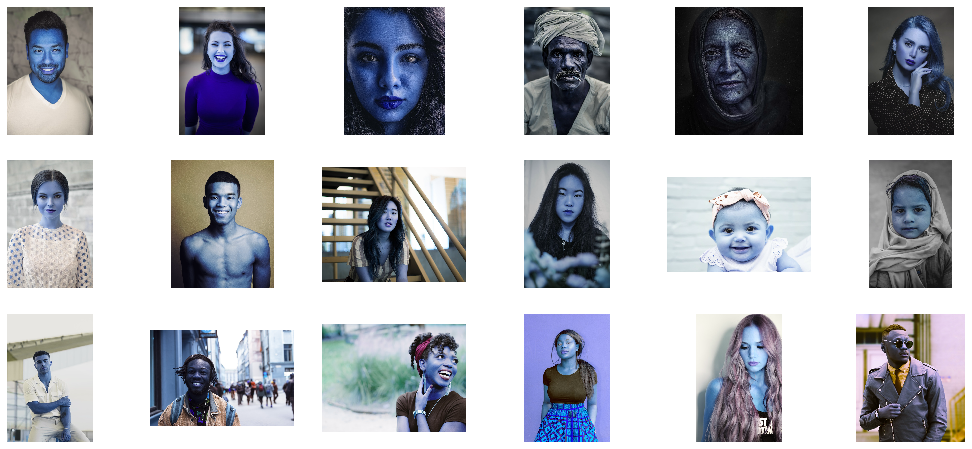

In [16]:
# Printing Scraped images
plt.figure(figsize=(18, 8))
for i in range(len(scraped_images)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(scraped_images[i], interpolation="nearest")
    plt.axis("off")
plt.show()

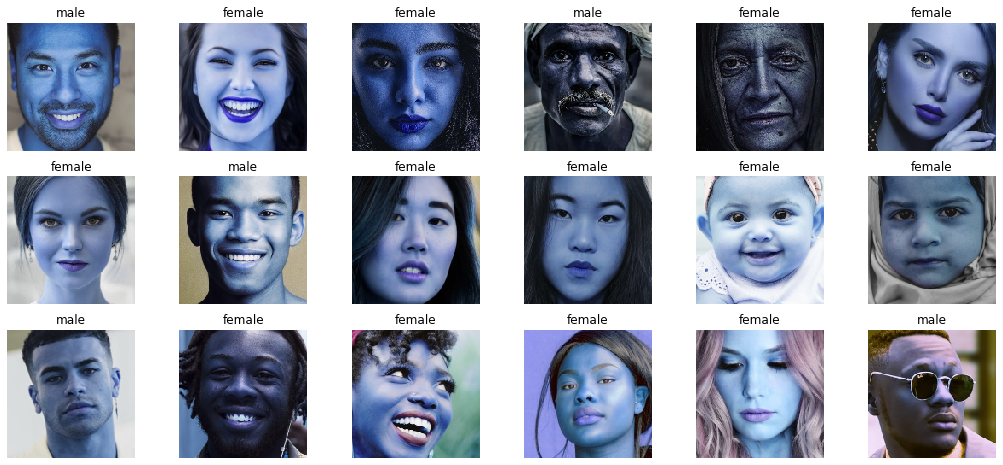

In [17]:
# Prediction on face images
classifier_prediction = classifier.predict(np.array(scraped_face_images))
classifier_prediction = np.where(classifier_prediction > best_threshold, 1, 0).ravel()

plt.figure(figsize=(18, 8))
for i in range(len(scraped_images)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(scraped_face_images[i], interpolation="nearest")
    plt.axis("off")
    plt.title(classes[classifier_prediction[i]])
plt.show()